In [1]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from keras.preprocessing.image import ImageDataGenerator
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.optimizers import adam
# baseline cnn model
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.optimizers import SGD
from os import listdir
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [2]:
# Carga del dataset
def load_dataset(trainPath, testPath):
    # Reescalamos las imagenes a 1./255
    train_datagen = ImageDataGenerator(rescale=1/255)
    validation_datagen = ImageDataGenerator(rescale=1/255)

    # Generamos batches de 120 imagenes de entrenamiento accediendo al directorio de imagenes de entrenamiento
    train_generator = train_datagen.flow_from_directory(
            trainPath,
            classes = ['incorrect', 'correct'],
            target_size=(200, 250),  # Todas las imagenes se redimensionan a 200x250
            batch_size=120, class_mode='binary')

    # Generamos batches de 19 imagenes de validación accediendo al directorio de imagenes de validación
    validation_generator = validation_datagen.flow_from_directory(
            testPath,
            classes = ['incorrect', 'correct'],
            target_size=(200, 250),  # Todas las imagenes se redimensionan a 200x250
            batch_size=19,
            # Usamos 
            class_mode='binary',
            shuffle=False)
    return train_generator, validation_generator

In [3]:
train_generator, validation_generator = load_dataset(r'C:\ejemplo_nuevo\train', r'C:\ejemplo_nuevo\validation')

Found 600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [4]:
# Definición del modelo
def define_model():
    model = Sequential()

    # Primera Capa Convolucional
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(200, 250, 3)))
    model.add(MaxPooling2D(2,2))
    # Segunda Capa Convolucional
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # Tercera Capa Convolucional
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # Cuarta Capa Convolucional
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # Quinta Capa Convolucional
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # Flatten the results to feed into a DNN
    model.add(Flatten())
    # 512 neuron hidden 
    model.add(Dense(512, activation='relu'))
    # Una neurona de salida. Devuelve un valor comprendido entre 0-1 donde 1 es 'correcto' y 0 'incorrecto'
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(optimizer = adam(lr=0.001, decay=1e-6), loss = 'binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# Entrenamiento del modelo
def train_model(model, train_generator, validation_generator):
    history = model.fit(train_generator,steps_per_epoch=8,epochs=15,verbose=1,validation_data = validation_generator,validation_steps=8)
    return history

In [6]:
# Evaluación del modelo
def evaluate_model(model, validation_generator, history):
    # evaluate a model using k-fold cross-validation
    scores, histories = list(), list()
    _, acc = model.evaluate(validation_generator)
    print('> %.3f' % (acc * 100.0))
    # Almacenamos las scores
    scores.append(acc)
    histories.append(history)
    return scores, histories

In [7]:
# Sacamos las metricas
def metrics(model, validation_generator):
    STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
    validation_generator.reset()
    preds = model.predict(validation_generator,
                      verbose=1)
    fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
# Mostramos las curvas de aprendizaje del modelo
def summarize_diagnostics(histories):
    # plot loss
    print(histories[0].history['loss'])
    print(histories[0].history)
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[0].history['loss'], color='blue', label='train')
    plt.plot(histories[0].history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[0].history['accuracy'], color='blue', label='train')
    plt.plot(histories[0].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [10]:
# Calculo de precisión del modelo
def summarize_performance(scores):
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    plt.boxplot(scores)
    plt.show()

In [11]:
def run_test_harness():
    print('iniciating definition of the model')

    # Definicion del modelo
    print('Definicion del modelo')
    model = define_model()

    # Entrenamiento del modelo
    print('Entrenamiento del modelo')
    history = train_model(model, train_generator, validation_generator)

    # Evaluación del modelo
    print('iniciating the evaluation of the model')
    scores, histories = evaluate_model(model, validation_generator, history)
    metrics(model, validation_generator)
    
    # Calculo de curvas de aprendizaje
    print('iniciating the diagnostics')
    summarize_diagnostics(histories)
    
    # Calculo de precision
    print('iniciating the diagnostic of performance')
    summarize_performance(scores)
    
    model.summary()
    # Guardado del modelo
    print('saving the model')
    model.save('final_model.h5')

iniciating definition of the model
Definicion del modelo
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 248, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 124, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 122, 32)       4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 29, 64)        0         
_______________________________________________________________

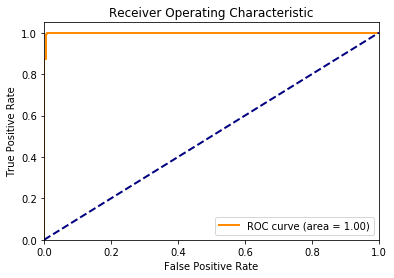

iniciating the diagnostics
[0.7119534909725189, 0.6860335096716881, 0.6525853499770164, 0.5372037664055824, 0.37948641180992126, 0.2115123076364398, 0.10164699889719486, 0.051701551768928766, 0.026967983692884445, 0.01109126659866888, 0.004348360424046405, 0.00474761426448822, 0.002349547685298603, 0.0006878379572299309, 0.00024016955376282567]
{'val_loss': [0.7012794017791748, 0.6916250586509705, 0.6220378875732422, 0.6842322945594788, 0.06190044805407524, 0.48772501945495605, 0.23324130475521088, 0.0002581128792371601, 0.008775216527283192, 0.10141073167324066, 0.12151765823364258, 0.0017550679622218013, 0.0019804490730166435, 0.0005615228437818587, 0.3655025064945221], 'val_accuracy': [0.0, 0.5592105388641357, 0.7761194109916687, 0.7302631735801697, 0.9539473652839661, 0.9179104566574097, 0.9539473652839661, 0.9934210777282715, 1.0, 0.9736841917037964, 1.0, 0.9934210777282715, 0.9934210777282715, 1.0, 0.9934210777282715], 'loss': [0.7119534909725189, 0.6860335096716881, 0.6525853499

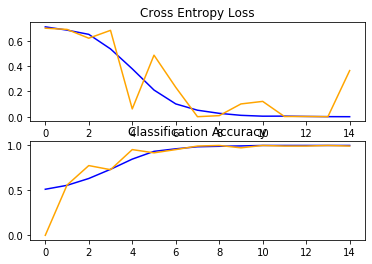

iniciating the diagnostic of performance
Accuracy: mean=99.500 std=0.000, n=1


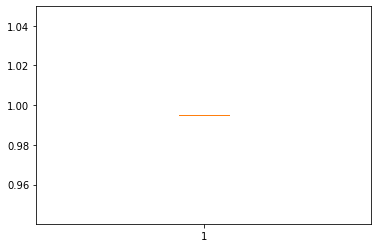

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 248, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 124, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 122, 32)       4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 29, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 27, 64)       

In [12]:
run_test_harness()

In [13]:
# Carga de imagen de test
def load_image(filename):
# load the image
    img = load_img(filename, grayscale=False, target_size=(800, 1000))
# convert to array
    img = img_to_array(img)
# reshape into a single sample with 1 channel
    img = img.reshape(3,400,500)
# prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [67]:
# Ejecución de ejemplo
def run_example():
    # Carga del modelo
    model = load_model('final_model.h5')
    
    # Carga de la imagen de prueba
    image = load_img('incorrecto3.png')
    input_arr = img_to_array(image, "channels_last")
    input_arr = np.array([input_arr])  # Convert single image to a batch.

    # Mostramos la imagen de prueba a predecir
    print("Imagen de ejemplo")
    image_to_show = array_to_img(input_arr[0], "channels_last")
    imgplot = plt.imshow(image_to_show)
    plt.show()
    
    # Prediccion de clases
    print("El diagrame es: ")
    digit = model.predict(input_arr)
    if(digit[0][0] < 0.5):
        print("Incorrecto")
    else: 
        print("Correcto")
    
    print("Con una score de: " + str(digit[0][0]))

In [95]:
# Ejecución de ejemplo
def run_example1(pathImages):
    # Carga del modelo
    model = load_model('final_model.h5')
    
    # Carga de imagenes de prueba
    onlyfiles = [f for f in os.listdir(pathImages) if os.path.isfile(os.path.join(pathImages, f))]
    train_files = []
    for _file in onlyfiles:
        train_files.append(_file)
        
    for _file in train_files: 
        image = load_img(pathImages + "/" + _file)
        input_arr = img_to_array(image, "channels_last")
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        
        # Mostramos la imagen de prueba a predecir
        print("Imagen de ejemplo")
        image_to_show = array_to_img(input_arr[0], "channels_last")
        imgplot = plt.imshow(image_to_show)
        plt.show()

        # Prediccion de clases
        print("El diagrama es: ")
        digit = model.predict(input_arr)
        percent = digit[0][0] * 100
        if(digit[0][0] < 0.5):
            percent = 100 - percent
            print("Incorrecto")
        else: 
            print("Correcto")

        print("Con una confianza del " + str(percent) + " %")

Imagen de ejemplo


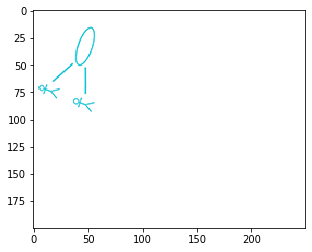

El diagrama es: 
Correcto
Con una confianza del 100.0 %
Imagen de ejemplo


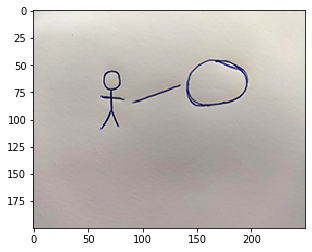

El diagrama es: 
Incorrecto
Con una confianza del 100.0 %
Imagen de ejemplo


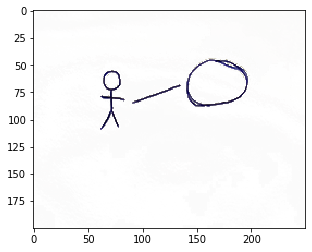

El diagrama es: 
Correcto
Con una confianza del 100.0 %
Imagen de ejemplo


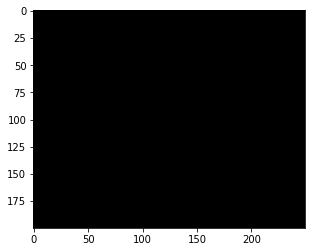

El diagrama es: 
Incorrecto
Con una confianza del 62.29791045188904 %
Imagen de ejemplo


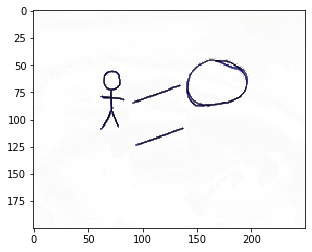

El diagrama es: 
Correcto
Con una confianza del 100.0 %
Imagen de ejemplo


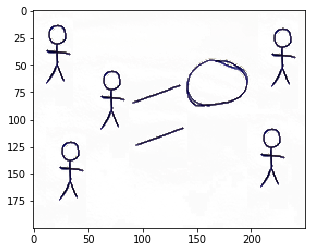

El diagrama es: 
Incorrecto
Con una confianza del 100.0 %


In [96]:
run_example1('imagenes_test')